# Scratch file for developing vivarium-comets

## Run COMETS from COMETSpy for just one square

In [1]:
import cometspy as c
import cobra.test
import matplotlib.pyplot as plt

In [2]:
# Check the cobra version
print(cobra.__version__)

0.22.1


### Create a layout for the simulation

In [3]:
# Create empty 1x1 layout
test_tube = c.layout()

# Add 11mM glucose
test_tube.set_specific_metabolite('glc__D_e', 0.011)

# Add infinite amount of oxygen
test_tube.set_specific_metabolite('o2_e', 1000)

# Add the rest of nutrients unlimited (ammonia, phosphate, water and protons)
test_tube.set_specific_metabolite('nh4_e',1000);
test_tube.set_specific_metabolite('pi_e',1000);
test_tube.set_specific_metabolite('h2o_e',1000);
test_tube.set_specific_metabolite('h_e',1000);

building empty layout model
models will need to be added with layout.add_model()


### Load a model

In [4]:
# create the model using CobraPy functionality
e_coli_cobra = cobra.test.create_test_model('textbook')
# use the loaded model to build a comets model
# Translate the cobra format into the comets format
e_coli = c.model(e_coli_cobra)

# remove the bounds from glucose import (will be set dynamically by COMETS)
# The bounds will be over written by the Michaelis-Menten kinetics
# By default the bounds are 0 and 1000, can cause problems
e_coli.change_bounds('EX_glc__D_e', -1000, 1000)
e_coli.change_bounds('EX_ac_e', -1000, 1000)

# set the model's initial biomass
# First two numbers are the x & y coordinates of the COMETS 2D grid
# COMETS uses 0 indexing, so 0 0 is the first square
e_coli.initial_pop = [0, 0, 5e-6]

# add it to the test_tube
test_tube.add_model(e_coli)

Using license file /usr/local/gurobi/gurobi.lic
Set parameter TokenServer to value sccsvc


### Set the simulation parameters

In [5]:
# Set the parameters that are different from the default
sim_params = c.params()

# Parameters of the uptake reactions
# Default values will be applied to all uptake reactions
# You can set the parameters for each model, but here we just have one model so setting for all the models is the same
sim_params.set_param('defaultVmax', 18.5)
# sim_params.set_param('defaultKm', 0.000015)
# Make Km much bigger, controls how 
sim_params.set_param('defaultKm', 0.000015)

# How many time steps in total are we running
sim_params.set_param('maxCycles', 1000)

# How long is each step
# Accuracy of the solution will depend on how big the time step is
sim_params.set_param('timeStep', 0.01)

# Size of the spatial box
# Unit is in cm
# Here we will have a volume of 1 mL
sim_params.set_param('spaceWidth', 1)

sim_params.set_param('maxSpaceBiomass', 10)

# Don't bother doing FBA where the biomass is really small
sim_params.set_param('minSpaceBiomass', 1e-11)

# Write the media so we can see how the media changes over time
sim_params.set_param('writeMediaLog', True)

### Run the simulation

In [6]:
# Define an experiment
experiment = c.comets(test_tube, sim_params)

In [7]:
experiment.run()


Running COMETS simulation ...
Done!


### Plot the results

#### Plot the biomass

In [8]:
experiment.total_biomass['e_coli_core'][1]

5.0555337427e-06

Text(0, 0.5, 'Biomass (gr.)')

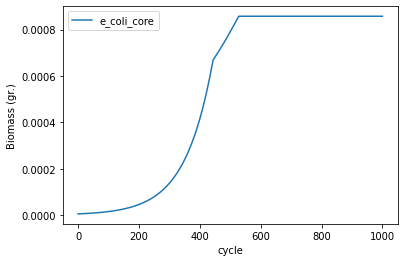

In [9]:
# Plot the biomass
ax = experiment.total_biomass.plot(x = 'cycle')
ax.set_ylabel("Biomass (gr.)")

#### Plot the metabolites

Text(0, 0.5, 'Concentration (mmol)')

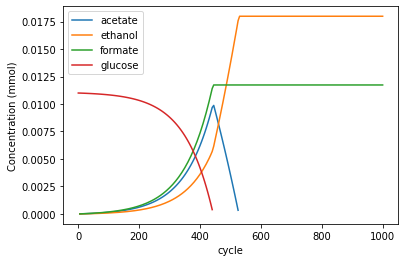

In [10]:
# Look the matbolites
# Only look at things less than 900 so that you don't see the infinite things, only look at thigs that are secreted
media = experiment.media.copy()
media = media[media.conc_mmol<900]

fig, ax = plt.subplots()
media.groupby('metabolite').plot(x='cycle', ax =ax, y='conc_mmol')
ax.legend(('acetate','ethanol', 'formate', 'glucose'))
ax.set_ylabel("Concentration (mmol)")

## Pull out the results I need for that square

I'll need:
1. Biomass
    * `experiment.total_biomass`
    * How to break out by the model?
2. Nutrients
    * `experiment.media`
    * Do I need to do .copy()
3. Diffusing biomass
    * Really don't know how to do this one

## Make a Vivarium Process

In [11]:
# Pip install to a specific location on the scc
# !pip install --target=/projectnb/cometsfba/pythonlibs/python3.8/site-packages vivarium-core

In [12]:
import matplotlib

In [13]:
# Process, Deriver, and Composer base classes
from vivarium.core.process import Process, Deriver
from vivarium.core.composer import Composer
from vivarium.core.registry import process_registry

In [51]:
# helper functions for composition
from vivarium.core.composition import (
    simulate_process,
    process_in_experiment,
    composer_in_experiment,
    composite_in_experiment)

# other vivarium imports
from vivarium.core.engine import Engine, pf
from vivarium.library.units import units

# plotting functions
from vivarium.plots.simulation_output import (
    plot_simulation_output, plot_variables)
from vivarium.plots.simulation_output import _save_fig_to_dir as save_fig_to_dir
from vivarium.plots.agents_multigen import plot_agents_multigen
from vivarium.plots.topology import plot_topology


In [36]:
class Comets(Process):
    
    defaults = {
        'dimensions': [1,1]
    }

    def __init__(self, parameters=None):
        super().__init__(parameters)
        dimensions = self.parameters['dimensions']
        
    def ports_schema(self):
        return {
            # Declare a port for biomass
            'Biomass': {
                # Define the variable that goees through that port
                'ecoli_biomass': {
                    # Define how that variable operates
                    '_default': 0.0,
                    '_updater': 'set', # Use set, since we are not returning the delta but the new value
                    '_emit': True}},
            
            # Use dictionary comprehension to declare schema for all the metabolites
            'Metabolites': {
#                 'metabolite_dictionary': {
                '*': {
                    '_default': 0.0,
                    '_updater': 'set',
                    '_emit': True
                }
            }
        }
    
    def next_update(self, timestep, states):
        # Parse variables from states
        biomass = states['Biomass']['ecoli_biomass']
        metabolites = states['Metabolites']
        
        # Run COMETS (need to use timestep somewhere in here)
        ##################################################################
        # Create empty 1x1 layout
        test_tube = c.layout()
        
        # Add all the metabolites
        # Kludge- loop through all the metabolites and set specific
        for met_id in metabolites:
            test_tube.set_specific_metabolite(met_id, metabolites[met_id])
        
        # Hard code loading the E coli model
        e_coli_cobra = cobra.test.create_test_model('textbook')
        # Translate the cobra format into the comets format
        e_coli = c.model(e_coli_cobra)

        # remove the bounds from glucose import (will be set dynamically by COMETS)
        # The bounds will be over written by the Michaelis-Menten kinetics
        # By default the bounds are 0 and 1000, can cause problems
        e_coli.change_bounds('EX_glc__D_e', -1000, 1000)
        e_coli.change_bounds('EX_ac_e', -1000, 1000)
        
        # set the model's initial biomass
        # First two numbers are the x & y coordinates of the COMETS 2D grid
        # COMETS uses 0 indexing, so 0 0 is the first square
        e_coli.initial_pop = [0, 0, biomass]

        # add it to the test_tube
        test_tube.add_model(e_coli)
        
        # Hardcode the simulation parameters
        sim_params = c.params()
        sim_params.set_param('defaultVmax', 18.5)
        sim_params.set_param('defaultKm', 0.000015)
        sim_params.set_param('maxCycles', 1)
        sim_params.set_param('timeStep', timestep)
        sim_params.set_param('spaceWidth', 1)
        sim_params.set_param('maxSpaceBiomass', 10)
        sim_params.set_param('minSpaceBiomass', 1e-11)
        sim_params.set_param('writeMediaLog', True)

        # Define an experiment
        experiment = c.comets(test_tube, sim_params)
    
        # Run the simulation
        experiment.run()
        ##################################################################
        
        # Get the next biomass and metabolites from the COMETS run
        next_biomass = experiment.total_biomass['e_coli_core'][1]
        next_metabolite = experiment.media.copy()
        print(next_metabolite)
        
        return {
            'Biomass': {
                'ecoli_biomass': next_biomass
            },
            'Metabolites': next_metabolite
        }

## Run the Vivarium Process

In [24]:
comets_config = {'time_step': .1, 'dimensions': [1,1]}
comets_sim_settings = {
    'experiment_id': 'foo'}
comets_initial_state = {
    'Biomass': {'ecoli_biomass': 0.000005},
    'Metabolites': {'glc__D_e': 0.011,
                    'o2_e': 1000,
                    'nh4_e': 1000,
                    'pi_e': 1000,
                    'h2o_e': 1000,
                    'h_e': 1000
                   }
}

In [46]:
# initialize
comets_process = Comets(comets_config)

comets_exp = Engine(processes={'comets': comets_process},
                    topology={
                        'comets': {'Biomass': ('Biomass',),
                                   'Metabolites': ('Metabolites',)}},
                   initial_state = comets_initial_state)

# make the experiment
# comets_exp = process_in_experiment(
#     comets_process, comets_sim_settings, comets_initial_state)

# run
comets_exp.update(1.0) # Same as the COMETS maxCycles


Simulation ID: adcb6d74-40de-11ed-8986-7cd30ad26602
Created: 09/30/2022 at 12:41:06
building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...
Done!
  metabolite  cycle  x  y  conc_mmol
0   glc__D_e      0  1  1      0.011
1      h2o_e      0  1  1   1000.000
2        h_e      0  1  1   1000.000
3      nh4_e      0  1  1   1000.000
4       o2_e      0  1  1   1000.000
5       pi_e      0  1  1   1000.000
building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...
Done!
  metabolite  cycle  x  y  conc_mmol
0   glc__D_e      0  1  1      0.011
1      h2o_e      0  1  1   1000.000
2        h_e      0  1  1   1000.000
3      nh4_e      0  1  1   1000.000
4       o2_e      0  1  1   1000.000
5       pi_e      0  1  1   1000.000
building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...
Done!
  metabolite  cycle  x  y  conc_mmol
0   gl


Running COMETS simulation ...
Done!
  metabolite  cycle  x  y  conc_mmol
0   glc__D_e      0  1  1      0.011
1      h2o_e      0  1  1   1000.000
2        h_e      0  1  1   1000.000
3      nh4_e      0  1  1   1000.000
4       o2_e      0  1  1   1000.000
5       pi_e      0  1  1   1000.000
building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...
Done!
  metabolite  cycle  x  y  conc_mmol
0   glc__D_e      0  1  1      0.011
1      h2o_e      0  1  1   1000.000
2        h_e      0  1  1   1000.000
3      nh4_e      0  1  1   1000.000
4       o2_e      0  1  1   1000.000
5       pi_e      0  1  1   1000.000
building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...
Done!
  metabolite  cycle  x  y  conc_mmol
0   glc__D_e      0  1  1      0.011
1      h2o_e      0  1  1   1000.000
2        h_e      0  1  1   1000.000
3      nh4_e      0  1  1   1000.000
4       o2_e      0  1  

In [52]:
print(pf(comets_exp.state.get_value()))

{ 'Biomass': {'ecoli_biomass': 1.5926297627e-05},
  'Metabolites': { 'glc__D_e': 0.011,
                   'h2o_e': 1000,
                   'h_e': 1000,
                   'nh4_e': 1000,
                   'o2_e': 1000,
                   'pi_e': 1000},
  'comets': ( <__main__.Comets object at 0x2b4c8ee55430>,
              {'Biomass': ('Biomass',), 'Metabolites': ('Metabolites',)})}


In [53]:
print(pf(comets_exp.state.get_config()))

{ 'Biomass': { 'ecoli_biomass': { '_default': 0.0,
                                  '_emit': True,
                                  '_updater': <function update_set at 0x2b4c8ba9cca0>,
                                  '_value': 1.5926297627e-05}},
  'Metabolites': { '_subschema': { '_default': 0.0,
                                   '_emit': True,
                                   '_updater': 'set'},
                   'glc__D_e': { '_default': 0.0,
                                 '_emit': True,
                                 '_updater': <function update_set at 0x2b4c8ba9cca0>,
                                 '_value': 0.011},
                   'h2o_e': { '_default': 0.0,
                              '_emit': True,
                              '_updater': <function update_set at 0x2b4c8ba9cca0>,
                              '_value': 1000},
                   'h_e': { '_default': 0.0,
                            '_emit': True,
                            '_updater': <functi

In [47]:
# retrieve the data as a timeseries
comets_output = comets_exp.emitter.get_timeseries()

In [54]:
comets_exp.emitter.get_data()

{0: {'Biomass': {'ecoli_biomass': 5e-06},
  'Metabolites': {'glc__D_e': 0.011,
   'o2_e': 1000,
   'nh4_e': 1000,
   'pi_e': 1000,
   'h2o_e': 1000,
   'h_e': 1000}},
 0.1: {'Biomass': {'ecoli_biomass': 5.5553374271e-06},
  'Metabolites': {'glc__D_e': 0.011,
   'o2_e': 1000,
   'nh4_e': 1000,
   'pi_e': 1000,
   'h2o_e': 1000,
   'h_e': 1000}},
 0.2: {'Biomass': {'ecoli_biomass': 6.1723547858e-06},
  'Metabolites': {'glc__D_e': 0.011,
   'o2_e': 1000,
   'nh4_e': 1000,
   'pi_e': 1000,
   'h2o_e': 1000,
   'h_e': 1000}},
 0.30000000000000004: {'Biomass': {'ecoli_biomass': 6.8579027109e-06},
  'Metabolites': {'glc__D_e': 0.011,
   'o2_e': 1000,
   'nh4_e': 1000,
   'pi_e': 1000,
   'h2o_e': 1000,
   'h_e': 1000}},
 0.4: {'Biomass': {'ecoli_biomass': 7.6195927202e-06},
  'Metabolites': {'glc__D_e': 0.011,
   'o2_e': 1000,
   'nh4_e': 1000,
   'pi_e': 1000,
   'h2o_e': 1000,
   'h_e': 1000}},
 0.5: {'Biomass': {'ecoli_biomass': 8.4658817235e-06},
  'Metabolites': {'glc__D_e': 0.011,
   'o

In [48]:
comets_output

{'Biomass': {'ecoli_biomass': [5e-06,
   5.5553374271e-06,
   6.1723547858e-06,
   6.8579027109e-06,
   7.6195927202e-06,
   8.4658817235e-06,
   9.4061659183e-06,
   1.0450885114e-05,
   1.1611638644e-05,
   1.290131415e-05,
   1.4334230671e-05,
   1.5926297627e-05]},
 'Metabolites': {'glc__D_e': [0.011,
   0.011,
   0.011,
   0.011,
   0.011,
   0.011,
   0.011,
   0.011,
   0.011,
   0.011,
   0.011,
   0.011],
  'o2_e': [1000,
   1000,
   1000,
   1000,
   1000,
   1000,
   1000,
   1000,
   1000,
   1000,
   1000,
   1000],
  'nh4_e': [1000,
   1000,
   1000,
   1000,
   1000,
   1000,
   1000,
   1000,
   1000,
   1000,
   1000,
   1000],
  'pi_e': [1000,
   1000,
   1000,
   1000,
   1000,
   1000,
   1000,
   1000,
   1000,
   1000,
   1000,
   1000],
  'h2o_e': [1000,
   1000,
   1000,
   1000,
   1000,
   1000,
   1000,
   1000,
   1000,
   1000,
   1000,
   1000],
  'h_e': [1000,
   1000,
   1000,
   1000,
   1000,
   1000,
   1000,
   1000,
   1000,
   1000,
   1000,
   100

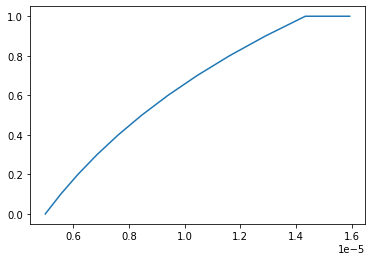

In [55]:
# plot
plt.plot(comets_output['Biomass']['ecoli_biomass'], comets_output['time'])